In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Classic Machine Learning Techniques
Supervised Learning  -- correggi: intercation, iteration

In [2]:
seed = 42
np.random.seed(seed)

df = pd.read_csv('dataset.csv')
display(df.head())
print(f'Number of samples: {df.shape[0]}')

,rating_mean,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3.893708,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0,0,0,0,0,0,0,0,0,0
1,3.251527,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0,0,0,0,0,0,0,0,0,0
2,3.142028,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0,0,0,0,0,1,0,0,0,0
3,2.853547,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,...,0,0,0,0,0,1,0,0,0,0
4,3.058434,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,...,0,0,0,0,0,0,0,0,0,0


Number of samples: 13798


### Data Preprocessing

In [3]:
X = df.drop('rating_mean', axis=1)
y = df['rating_mean']

# Train Test and Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

print('Number of training samples:', X_train.shape)
print('Number of testing samples:', X_test.shape)
print('Number of validation samples:', X_val.shape)

Number of training samples: (9934, 1147)
Number of testing samples: (2760, 1147)
Number of validation samples: (1104, 1147)


# Models
### Linear Regression

In [4]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Linear Regression Results:')
print('Mean Square Error:', mse)
print('R2 Score:', r2)

Linear Regression Results:
Mean Square Error: 0.005323422327103108
R2 Score: 0.9763990355736917


### Ridge Regression

In [20]:
from sklearn.linear_model import Ridge

alphas = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]

best_mse = None
best_alpha = None
best_model = None

results = []

i = 0
for alpha in alphas:
    i += 1
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X_train, y_train)
    y_pred = ridge_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = ridge_regressor

    results.append((i, alpha, mse))

    print('Iteration: {} - Alpha: {} - MSE: {}\n'.format(i, alpha, mse))


y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Ridge Regression Best Results:')
print('Alpha:', best_alpha)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 - Alpha: 0.001 - MSE: 0.005136250310036589

Iteration: 2 - Alpha: 0.01 - MSE: 0.005135624667279113

Iteration: 3 - Alpha: 0.1 - MSE: 0.0051295839834273665

Iteration: 4 - Alpha: 0.5 - MSE: 0.005107762264930731

Iteration: 5 - Alpha: 1 - MSE: 0.005090214586656224

Iteration: 6 - Alpha: 5 - MSE: 0.005096844967708207

Iteration: 7 - Alpha: 10 - MSE: 0.005198389864605277

Ridge Regression Best Results:
Alpha: 1
Mean Square Error: 0.005090214586656224
R2 Score: 0.9767451183185097


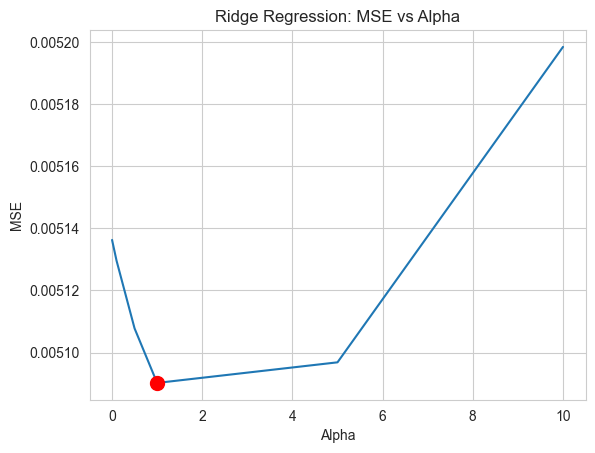

In [24]:
results = pd.DataFrame(results, columns=['Iteration', 'Alpha', 'MSE'])

sns.lineplot(x='Alpha', y='MSE', data=results)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Ridge Regression: MSE vs Alpha')
plt.scatter(best_alpha, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

### Lasso Regression

In [5]:
from sklearn.linear_model import Lasso

alphas = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_mse = None
best_alpha = None
best_model = None

results = []

i = 0
for alpha in alphas:
    i += 1
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X_train, y_train)
    y_pred = lasso_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = lasso_regressor

    results.append((i, alpha, mse))

    print('Iteration: {} - Alpha: {} - MSE: {}\n'.format(i, alpha, mse))

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Lasso Regression Best Results:')
print('Alpha:', best_alpha)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 - Alpha: 0.01 - MSE: 0.031704750398895754

Iteration: 2 - Alpha: 0.001 - MSE: 0.01042956200834075



D:\Workspace\data-analytics-movielens\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.186e+00, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 3 - Alpha: 0.0001 - MSE: 0.005425329960428212



D:\Workspace\data-analytics-movielens\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e+01, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 4 - Alpha: 1e-05 - MSE: 0.005098755273247195

Iteration: 5 - Alpha: 1e-06 - MSE: 0.005312812758593546

Lasso Regression Best Results:
Alpha: 1e-05
Mean Square Error: 0.005098755273247195
R2 Score: 0.9766021437075746


D:\Workspace\data-analytics-movielens\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.095e+01, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


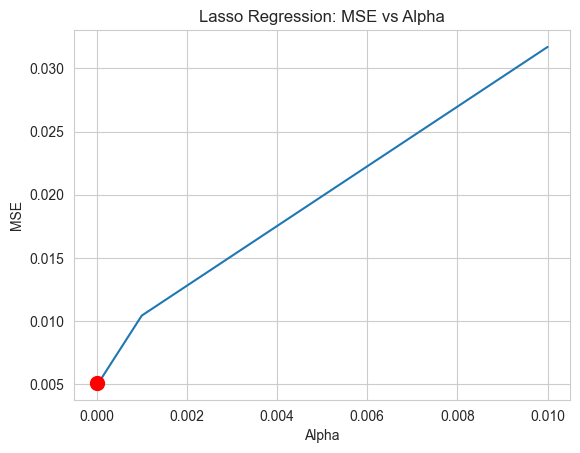

In [6]:
results = pd.DataFrame(results, columns=['Iteration', 'Alpha', 'MSE'])

sns.lineplot(x='Alpha', y='MSE', data=results)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Lasso Regression: MSE vs Alpha')
plt.scatter(best_alpha, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

### Elastic Net Regression

In [7]:
from sklearn.linear_model import ElasticNet

alphas = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

best_mse = None
best_alpha = None
best_model = None

results = []

i = 0
for alpha in alphas:
    i += 1
    elastic_net_regressor = ElasticNet(alpha=alpha)
    elastic_net_regressor.fit(X_train, y_train)
    y_pred = elastic_net_regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = elastic_net_regressor

    results.append((i, alpha, mse))

    print('Iteration: {} - Alpha: {} - MSE: {}\n'.format(i, alpha, mse))

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('Elastic Net Regression Best Results:')
print('Alpha:', best_alpha)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 - Alpha: 0.01 - MSE: 0.02170597208741899

Iteration: 2 - Alpha: 0.001 - MSE: 0.008141881191686079



D:\Workspace\data-analytics-movielens\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e+01, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 3 - Alpha: 0.0001 - MSE: 0.005167175808787863



D:\Workspace\data-analytics-movielens\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e+01, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


Iteration: 4 - Alpha: 1e-05 - MSE: 0.005196817389722953

Iteration: 5 - Alpha: 1e-06 - MSE: 0.005328103008523953

Elastic Net Regression Best Results:
Alpha: 0.0001
Mean Square Error: 0.005167175808787863
R2 Score: 0.9769949222547787


D:\Workspace\data-analytics-movielens\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.092e+01, tolerance: 2.359e-01
  model = cd_fast.enet_coordinate_descent(


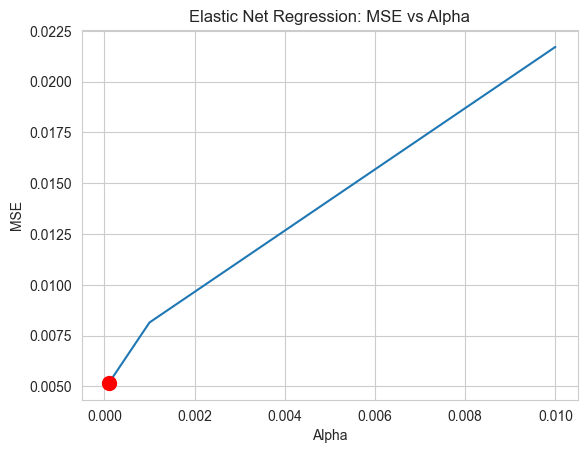

In [8]:
results = pd.DataFrame(results, columns=['Iteration', 'Alpha', 'MSE'])

sns.lineplot(x='Alpha', y='MSE', data=results)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Elastic Net Regression: MSE vs Alpha')
plt.scatter(best_alpha, best_mse, color='red', marker='o', s=100, zorder=3)
plt.show()

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=seed)
rf_regressor.fit(X_train, np.ravel(y_train))

y_pred = rf_regressor.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print('Mean Square Error:', mse)
print('R2 Score:', r2)

print('Accuracy:', rf_regressor.score(X_test, y_test))
rankVar = pd.Series(rf_regressor.feature_importances_, index=X.columns).sort_values(ascending=False)
print(rankVar)

sns.barplot(x=rankVar[:10], y=rankVar.index[:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Top 10 Features")
plt.show()

### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=seed)
gb_regressor.fit(X_train, np.ravel(y_train))

y_pred = gb_regressor.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print('Mean Square Error:', mse)
print('R2 Score:', r2)

print('Accuracy:', gb_regressor.score(X_test, y_test))

rankVar = pd.Series(gb_regressor.feature_importances_, index=X.columns).sort_values(ascending=False)

sns.barplot(x=rankVar[:10], y=rankVar.index[:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Top 10 Features")
plt.show()

### Support Vector Regressor

In [4]:
from sklearn.svm import SVR
## da fixzare
c = [0.001, 0.01, 0.1, 1, 5]
epsilon = [0.001, 0.01, 0.1, 1, 5]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

best_mse = None
best_r2 = None
best_c = None
best_epsilon = None
best_kernel = None

results = []

i = 0

for c in c:
    for epsilon in epsilon:
        for kernel in kernel:
            i += 1
            svr_regressor = SVR(C=c, epsilon=epsilon, kernel=kernel)
            svr_regressor.fit(X_train, np.ravel(y_train))
            y_pred = svr_regressor.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)

            if best_mse is None or mse < best_mse:
                best_mse = mse
                best_r2 = r2
                best_c = c
                best_epsilon = epsilon
                best_kernel = kernel

            results.append((i, c, epsilon, kernel, mse, r2))

            print('Iteration: {} - C: {} - Epsilon: {} - Kernel: {} - MSE: {} - R2: {}\n'.format(i, c, epsilon, kernel,
                                                                                                 mse, r2))

print('Support Vector Regression Best Results:')
print('C:', best_c)
print('Epsilon:', best_epsilon)
print('Kernel:', best_kernel)
print('Mean Square Error:', best_mse)
print('R2 Score:', best_r2)


Interaction: 1 - C: 0.001 - Epsilon: 0.001 - Kernel: linear - MSE: 0.00781528718756544 - R2: 0.9653515532750361

Interaction: 2 - C: 0.001 - Epsilon: 0.001 - Kernel: poly - MSE: 0.07344464084408064 - R2: 0.6743890960822185

Interaction: 3 - C: 0.001 - Epsilon: 0.001 - Kernel: rbf - MSE: 0.0985468736736527 - R2: 0.5631003672103104

Interaction: 4 - C: 0.001 - Epsilon: 0.001 - Kernel: sigmoid - MSE: 0.1367003482992314 - R2: 0.39395000827789173



InvalidParameterError: The 'kernel' parameter of SVR must be a str among {'sigmoid', 'linear', 'precomputed', 'poly', 'rbf'} or a callable. Got 's' instead.

### Naive Bayes Classifier (GaussianNB)
Non ottimo prende solo valori interi
https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train.astype('int'))

y_pred = nb_classifier.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print('Mean Square Error:', mse)
print('R2 Score:', r2)
print('Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test.astype('int'), y_pred)))

# Check for overfitting
print('Checking for overfitting:')
print('Training set score: {:.4f}'.format(nb_classifier.score(X_train, y_train.astype('int'))))
print('Test set score: {:.4f}'.format(nb_classifier.score(X_test, y_test.astype('int'))))

# Confusion matrix
cm = confusion_matrix(y_test.astype('int'), y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

print('False Positives:', FP)
print('False Negatives:', FN)
print('True Positives:', TP)
print('True Negatives:', TN)

Mean Square Error: 0.5833139191273528
R2 Score: -1.5858385159160093


ValueError: Found input variables with inconsistent numbers of samples: [2760, 1104]

### K-Nearest Neighbors
è un classificatore non un regressore

In [9]:
from sklearn.neighbors import KNeighborsRegressor

n_neighbors = [3, 5, 7, 9, 11, 13, 15, 17, 19]

best_mse = None
best_n_neighbors = None
best_model = None

results = []

i = 0
for n in n_neighbors:
    i += 1
    knn_classifier = KNeighborsRegressor(n_neighbors=n)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_n_neighbors = n
        best_model = knn_classifier

    results.append((i, n, mse))

    print('Iteration: {} - N: {} - MSE: {}\n'.format(i, n, mse))

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('K-Nearest Neighbors Best Results:')
print('N:', best_n_neighbors)
print('Mean Square Error:', best_mse)
print('R2 Score:', r2)

Iteration: 1 - N: 3 - MSE: 0.053922594467955186

Iteration: 2 - N: 5 - MSE: 0.047949721487423345

Iteration: 3 - N: 7 - MSE: 0.04668300182271503

Iteration: 4 - N: 9 - MSE: 0.04550905981364089

Iteration: 5 - N: 11 - MSE: 0.045281859614944214

Iteration: 6 - N: 13 - MSE: 0.04565773792225886

Iteration: 7 - N: 15 - MSE: 0.04555853739032508

Iteration: 8 - N: 17 - MSE: 0.04613432323891831

Iteration: 9 - N: 19 - MSE: 0.046658073742981816

K-Nearest Neighbors Best Results:
N: 11
Mean Square Error: 0.045281859614944214
R2 Score: 0.7964074169165131


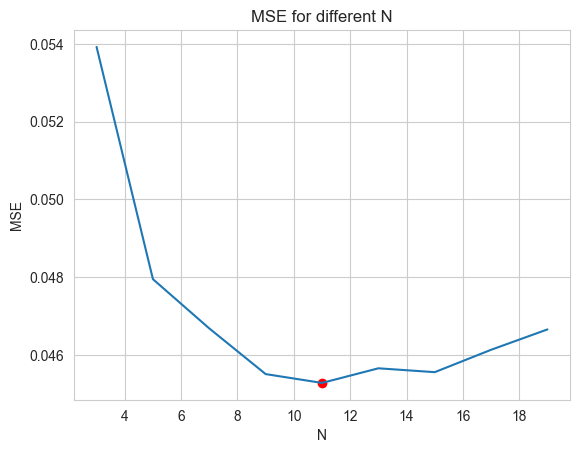

In [11]:
results = pd.DataFrame(results, columns=['Iteration', 'N', 'MSE'])

sns.lineplot(x='N', y='MSE', data=results)
plt.xlabel('N')
plt.ylabel('MSE')
plt.title('MSE for different N')
plt.scatter(best_n_neighbors, best_mse, color='red')
plt.show()